# Calculating Barriers in Metal - Semiconductor junctions 
- all calculations indepandant of the material
- for both p and n-type


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pandas as pd

### Physical Constants

In [2]:
Q = 1.602e-19  # Elementary charge (C)
EPSILON_0 = 8.854e-14  # Permittivity of free space (As/Vcm) -> in cm here to math the doping concentration units
K_B_eV = 8.617e-5  # Boltzmann constant (eV/K)
K_B_J = 1.380649e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
H = 6.626e-34# planck constant (Js)

### Material Parameters Class
allows for easier swaps of materials

In [3]:
class MaterialParameters:
    """Stores and manages the material parameters for the semiconductor and metal."""
    def __init__(self, name, type, phi_s, chi, Nd_or_Na, epsilon_r, Nc=None, Nv=None, phi_0_CNL=None):
        """
        :param name: Material name (e.g., 'Silicon', 'Aluminium').
        :param type: 'n' or 'p' for semiconductor, 'metal' for metal.
        :param phi_s: Work function (eV) for metal OR band gap (Eg) for semiconductor.
        :param chi: Electron Affinity (eV) for semiconductor.
        :param Nd_or_Na: Donor (Nd) or Acceptor (Na) concentration (atoms/cm^3) for semiconductor.
        :param epsilon_r: Relative permittivity (dielectric constant).
        :param Nc: Effective Density of States in Conduction Band (cm^-3).
        :param Nv: Effective Density of States in Valence Band (cm^-3).
        :param phi_0_CNL: charge neutrality level (eV).
        """
        self.name = name
        self.type = type
        self.phi_s = phi_s # Work function or Eg
        self.chi = chi
        self.Nd_or_Na = Nd_or_Na
        self.epsilon_r = epsilon_r
        # Calculate absolute permittivity (F/cm)
        if self.epsilon_r is not None: self.epsilon = self.epsilon_r * EPSILON_0
        
        self.Nc = Nc
        self.Nv = Nv
        self.phi_0_CNL = phi_0_CNL

### Junction Calculation Class
- ideal barrier
- fermi level pinning
- depletion width

In [4]:
class JunctionCalculator:
    """Performs calculations for the metal-semiconductor junction."""

    def __init__(self, metal, semiconductor):
        self.metal = metal
        self.semiconductor = semiconductor
        self.type = semiconductor.type.lower() # 'n' or 'p'


    def _calculate_fermi_level_position(self):
        """
        Calculates the Fermi level position relative to the band edge (in eV).
        This result is E_c - E_F for n-type or E_F - E_v for p-type.
        """
        kBT_over_q = K_B_eV * T # k_B T/q (in Volts)

        if self.type == 'n':
            # E_C-E_F = k_B T/q * ln (N_D/N_C) (in V)
                        
            # NOTE: We must ensure N_D < N_C for the Boltzmann approximation to be valid
            N_D = self.semiconductor.Nd_or_Na
            N_C = self.semiconductor.Nc
            
            if N_D > N_C:
                # Fermi level is in the conduction band (degenerate case)
                print("n--- WARNING: Degenerate doping (ND > NC). Result may be inaccurate. ---")
            
            V_n = kBT_over_q * np.log(self.semiconductor.Nc / N_D)
            return V_n
            
        elif self.type == 'p':
            # E_F - E_V = k_B T/q * ln(N_A/N_V) (in V)
            N_A = self.semiconductor.Nd_or_Na
            N_V = self.semiconductor.Nv

            if N_A > N_V:
                print("n--- WARNING: Degenerate doping (NA > NV). Result may be inaccurate. ---")
                
            V_p = kBT_over_q * np.log(self.semiconductor.Nv / N_A)
            return V_p
        
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'.")


    def _calculate_v_bi(self):
            """
            Calculates the built-in potential (V_bi) based on the Schottky-Mott model:
            V_bi = 1/q * (Phi_m - Phi_s), where Phi_s is the semiconductor work function.
            
            V_bi (n-type) = Phi_m - chi - V_n       (in Volts)
            V_bi (p-type) = Phi_m - chi - E_g + V_p (in Volts)
            
            Where Phi_m, chi, E_g are in eV and V_n, V_p are in Volts.
            Since V_n and V_p are already calculated in Volts, the formula simplifies.
            """
            phi_m = self.metal.phi_s        # Phi_m (eV)
            chi = self.semiconductor.chi    # chi (eV)
            Eg = self.semiconductor.phi_s   # E_g (eV)

            # Fermi level position relative to band edge, V_n or V_p (in Volts)
            V_fermi_band_edge = self._calculate_fermi_level_position() 

            if self.type == 'n':
                # The semiconductor work function is Phi_s = chi + (E_c - E_F)/q = chi + V_n
                # V_bi = (Phi_m - Phi_s)/q
                # V_bi = Phi_m - chi - V_fermi_band_edge
                V_bi = phi_m - chi - V_fermi_band_edge
                
            elif self.type == 'p':
                # The semiconductor work function is Phi_s = chi + E_g - (E_F - E_v)/q = chi + E_g - V_p
                # V_bi = Phi_m - (chi + E_g - V_fermi_band_edge)
                V_bi = phi_m - (chi + Eg - V_fermi_band_edge)
            
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'.")
                
            return V_bi



    def ideal_barrier_height(self):
            """
            Calculates the ideal Schottky Barrier Height Phi_B,ideal
            """
            phi_m = self.metal.phi_s # Metal work function (eV)
            chi = self.semiconductor.chi # Electron Affinity (eV)
            
            if self.type == 'n':
                # Phi_{Bn, ideal} = Phi_m - chi
                phi_b_ideal = phi_m - chi
            elif self.type == 'p':
                Eg = self.semiconductor.phi_s # Band gap (eV)
                # Phi_{Bp, ideal} = E_g - (Phi_m - chi)
                phi_b_ideal = Eg - (phi_m - chi)
            else:
                raise ValueError("Semiconductor type must be 'n' or 'p'")

            return phi_b_ideal
        
        
    def barrier_height_pinning(self, S):
        """
        Calculates the barrier height with Fermi Level Pinning
        :param S: Pinning factor (0 < S < 1). S=1 is ideal, S=0 is full pinning.
        """
        phi_m = self.metal.phi_s # Metal work function (eV)
        chi = self.semiconductor.chi # Electron Affinity (eV)
        phi_0_CNL = self.semiconductor.phi_0_CNL # charge neutrality level (eV)
        E_g = self.semiconductor.phi_s # Band gap (eV)

        if self.type == 'n':
            Phi_B = S * (phi_m - chi) + (1 - S) * (E_g - phi_0_CNL)         # * phi_0_CNL or * *(E_g - phi_0_CNL)?
        elif self.type == 'p':
            Phi_B = S * (E_g + chi - phi_m) + (1 - S) * phi_0_CNL
        else:
            raise ValueError("Semiconductor type must be 'n' or 'p'")

        return Phi_B


    def depletion_width(self, V_ext=0):
            """
            Calculates the depletion width (W) at a given applied voltage (V_ext).
            Requires the built-in voltage (V_bi).
            """
            V_bi = self._calculate_v_bi()
            N = self.semiconductor.Nd_or_Na
            epsilon = self.semiconductor.epsilon

            # W = sqrt{2 epsilon (V_bi - V_a)/Q N}
            try:
                W = np.sqrt((2 * epsilon * (V_bi - V_ext)) / (Q * N))
            except ValueError:
                print("Error: (V_bi - V_ext) is negative. Check inputs or V_bi calculation.")
                W = 0
                
            return W * 1e7 # Convert cm to nm

# Testing

## Material definitions

In [5]:
# def SiC parameters
n_SiC = MaterialParameters(
    name='n-SiC',
    type='n',
    phi_s=3.26, # Eg (eV)
    chi=3.2,
    Nd_or_Na=4.33e17,
    epsilon_r=9.7,
    Nc=1.7e19,
    Nv=2.5e19,
    phi_0_CNL=1.51)

p_SiC = MaterialParameters(
    name='p-SiC',
    type='p',
    phi_s=3.26, # Eg (eV)
    chi=3.2,
    Nd_or_Na=1e19,
    epsilon_r=9.7,
    Nc=1.7e19,
    Nv=2.5e19,
    phi_0_CNL=1.51)

# ------------------------------------------------------------------

Ni2Si = MaterialParameters(
    name='Ni2Si',
    type='metal',
    phi_s=4.8,  # 4.6-4.8 eV
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

Ni = MaterialParameters(
    name='Ni',
    type='metal',
    phi_s=5.05, # 5.04 – 5.35 eV
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

Ti = MaterialParameters(
    name='Ti',
    type='metal',
    phi_s=4.33,
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

Al = MaterialParameters(
    name='Al',
    type='metal',
    phi_s=4.08, # 4.06 to 4.28 eV, though the exact value varies depending on the specific crystal face and surface conditions
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

TiNi = MaterialParameters(
    name='TiNi',
    type='metal',
    phi_s=4.15, # 4.15-4.1
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

TiAl = MaterialParameters(
    name='TiAl',
    type='metal',
    phi_s=4.8,
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

TiC = MaterialParameters(
    name='TiC',
    type='metal',
    phi_s=4.25,  # 4.1-4.4 eV
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

Ti3SiC2 = MaterialParameters(
    name='Ti3SiC2',
    type='metal',
    phi_s=4.6,  # Ti₃SiC₂ MAX phase 4.5-4.7 eV
    chi=None,
    Nd_or_Na=None,
    epsilon_r=None)

NiGe = MaterialParameters(
    name='NiGe',
    type='metal',
    phi_s=4.6,  # 4.6-4.8 eV increases with Ni content
    chi=None,  
    Nd_or_Na=None,
    epsilon_r=None)

print(n_SiC.__dict__)
print(Ni2Si.__dict__)

{'name': 'n-SiC', 'type': 'n', 'phi_s': 3.26, 'chi': 3.2, 'Nd_or_Na': 4.33e+17, 'epsilon_r': 9.7, 'epsilon': 8.588379999999999e-13, 'Nc': 1.7e+19, 'Nv': 2.5e+19, 'phi_0_CNL': 1.51}
{'name': 'Ni2Si', 'type': 'metal', 'phi_s': 4.8, 'chi': None, 'Nd_or_Na': None, 'epsilon_r': None, 'Nc': None, 'Nv': None, 'phi_0_CNL': None}


# Schottky-Mott Model

In [8]:
list_of_semiconductors = [n_SiC, p_SiC]
list_of_metals = [Ni2Si, Ni, Ti, Al, TiNi, TiAl, TiC, Ti3SiC2, NiGe]

all_barriers_data = []
for semiconductor in list_of_semiconductors:
    print(semiconductor.name)
    for metal in list_of_metals:
        phi_m = JunctionCalculator(metal, semiconductor).ideal_barrier_height()
        # print(f"Barrier Height ({semiconductor.name}/{metal.name}): {round(phi_m, 3)} eV")

        w_scr = JunctionCalculator(metal, semiconductor).depletion_width()
        # print(f"work function ({semiconductor.name}/{metal.name}): {round(w_scr, 3)} nm")
        row_data = {
            'Semiconductor': semiconductor.name,
            'Metal': metal.name,
            'Barrier_Height_eV': round(phi_m, 3),
            'Depletion_Width_nm': round(w_scr, 3)}
        all_barriers_data.append(row_data)

barriers = pd.DataFrame(all_barriers_data)
print(barriers)

n-SiC
p-SiC
   Semiconductor    Metal  Barrier_Height_eV  Depletion_Width_nm
0          n-SiC    Ni2Si               1.60              61.049
1          n-SiC       Ni               1.85              65.925
2          n-SiC       Ti               1.13              50.628
3          n-SiC       Al               0.88              44.092
4          n-SiC     TiNi               0.95              46.016
5          n-SiC     TiAl               1.60              61.049
6          n-SiC      TiC               1.05              48.632
7          n-SiC  Ti3SiC2               1.40              56.849
8          n-SiC     NiGe               1.40              56.849
9          p-SiC    Ni2Si               1.66                 NaN
10         p-SiC       Ni               1.41                 NaN
11         p-SiC       Ti               2.13                 NaN
12         p-SiC       Al               2.38                 NaN
13         p-SiC     TiNi               2.31                 NaN
14         p-

C:\Users\Lutz_Laptop\AppData\Local\Temp\ipykernel_9048\2924616265.py:133: RuntimeWarning: invalid value encountered in sqrt
  W = np.sqrt((2 * epsilon * (V_bi - V_ext)) / (Q * N))


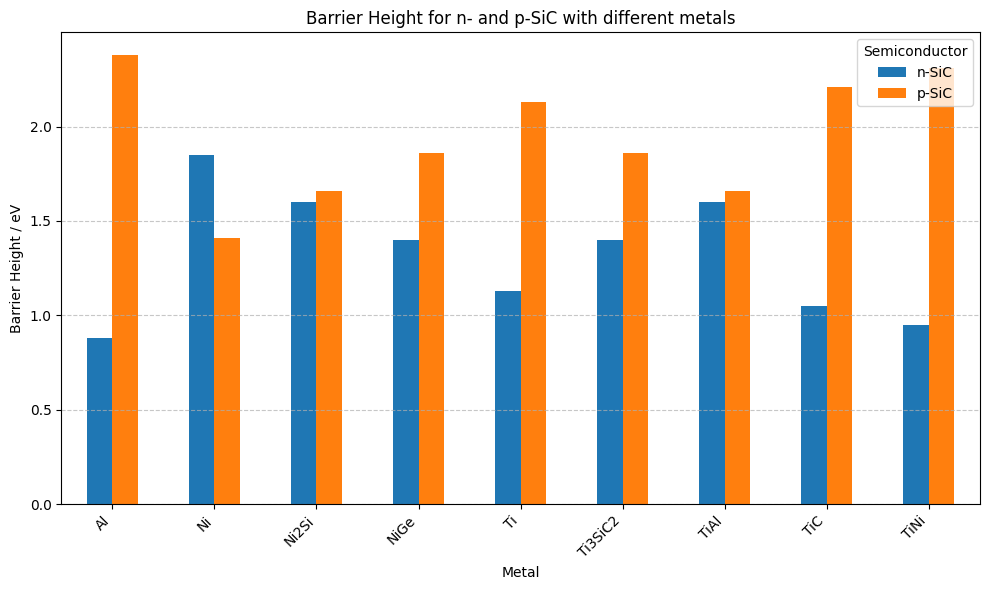

In [11]:
# Pivot for grouped plotting
pivot_df = barriers.pivot(index="Metal", columns="Semiconductor", values="Barrier_Height_eV")
# print(pivot_df)

pivot_df.plot(kind="bar", figsize=(10, 6))
plt.title("Barrier Height for n- and p-SiC with different metals")
plt.ylabel("Barrier Height / eV")
plt.xlabel("Metal")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Semiconductor")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

[np.float64(1.7499999999999998), np.float64(1.7484848484848485), np.float64(1.7469696969696966), np.float64(1.7454545454545454), np.float64(1.7439393939393937), np.float64(1.7424242424242422), np.float64(1.7409090909090907), np.float64(1.7393939393939393), np.float64(1.7378787878787876), np.float64(1.736363636363636), np.float64(1.7348484848484846), np.float64(1.7333333333333332), np.float64(1.7318181818181815), np.float64(1.7303030303030302), np.float64(1.7287878787878785), np.float64(1.727272727272727), np.float64(1.7257575757575754), np.float64(1.7242424242424241), np.float64(1.7227272727272722), np.float64(1.721212121212121), np.float64(1.7196969696969697), np.float64(1.7181818181818178), np.float64(1.7166666666666663), np.float64(1.7151515151515149), np.float64(1.7136363636363634), np.float64(1.7121212121212117), np.float64(1.7106060606060605), np.float64(1.709090909090909), np.float64(1.7075757575757573), np.float64(1.7060606060606058), np.float64(1.7045454545454546), np.float64(

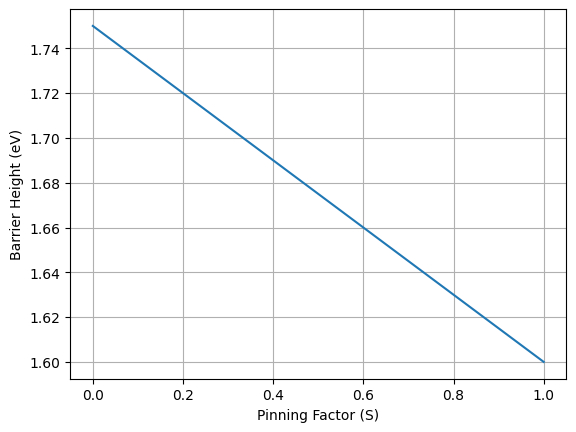

In [ ]:
# make a sweep of the pinning factor S from 0 to 1
S_values = np.linspace(0, 1, 100)
phi_b_pinning = [JunctionCalculator(Ni2Si, n_SiC).barrier_height_pinning(s) for s in S_values]
print(phi_b_pinning)

plt.plot(S_values, phi_b_pinning)
plt.xlabel('Pinning Factor (S)')
plt.ylabel('Barrier Height (eV)')
plt.grid()
plt.show()

maybe make plot using the density of interface states vs. the barrier hight

### using Thermonic Field Emission (TFE) / Field Emission (FE) mechanisms :
$R_c \propto \exp\left(\frac{q\Phi_B}{\sqrt{N}}\right)$

calculate specific tunneling factor $\frac{k_BT}{qE_{00}}$ \
=> indicates relevance of TE vs. FE mechanisms


In [ ]:
E_00 = H/(4*np.pi) * np.sqrt(N_D/(m_p*epsilon))

NameError: name 'N_D' is not defined

In [ ]:
# def main():
#     print("Metal-Semiconductor Junction Calculator")
#     pass


# if __name__ == "__main__":
#     main()